In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from typing import List, Dict, Tuple
import os
import glob

# Metrics
from scipy.stats import kendalltau
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

from utils import *

%matplotlib inline

In [2]:
path = "data"

In [3]:
all_files = glob.glob(os.path.join(path, "*.csv"))

ls_df = []

for file in all_files:
    mut_rob_df = pd.read_csv(file)
    if "12minis" in file:
        mut_rob_df["gene"] = mut_rob_df["gene"].str[4:]
        mut_rob_df[mut_rob_df.gene == "_wt"] = "cgre"
        mut_rob_df = mut_rob_df[["gene", "cdf_mu", "edited_n_aamut"]]
        mut_rob_df.rename(
            columns={"cdf_mu": "brightness", "edited_n_aamut": "n_aamut"}, inplace=True
        )
    else:
        mut_rob_df["gene"] = file.split("cgre")[1].split("_")[0]
        mut_rob_df = mut_rob_df[["gene", "brightness", "n_aamut"]]

    ls_df.append(mut_rob_df)

mut_rob_df = pd.concat(ls_df, axis=0, ignore_index=True)
mut_rob_df.drop(mut_rob_df[mut_rob_df.n_aamut == "cgre"].index, inplace=True)
mut_rob_df["n_aamut"] = pd.to_numeric(mut_rob_df["n_aamut"])
mut_rob_df["gene"] = mut_rob_df["gene"].astype(int)
mut_rob_df["brightness"] = mut_rob_df["brightness"].astype(float)

In [6]:
wt_cgre_df = pd.read_csv("amacGFP_cgreGFP_ppluGFP2_final_aminoacid_genotypes_to_brightness.csv")
wt_cgre_df = wt_cgre_df.loc[wt_cgre_df.gene == "cgreGFP"]
wt_cgre_df["n_aamut"] = wt_cgre_df.aa_genotype_native.str.count(":") + 1
wt_cgre_df.loc[wt_cgre_df.aa_genotype_native == "wt", "n_aamut"] = 0
wt_cgre_df.drop(labels=["aa_genotype_pseudo", "aa_genotype_native", "total_cell_count", "n_replicates"], axis=1, inplace=True)
wt_cgre_df.rename(
            columns={"replicates_mean_brightness": "brightness"}, inplace=True
        )
mut_rob_df = pd.concat([wt_cgre_df, mut_rob_df])

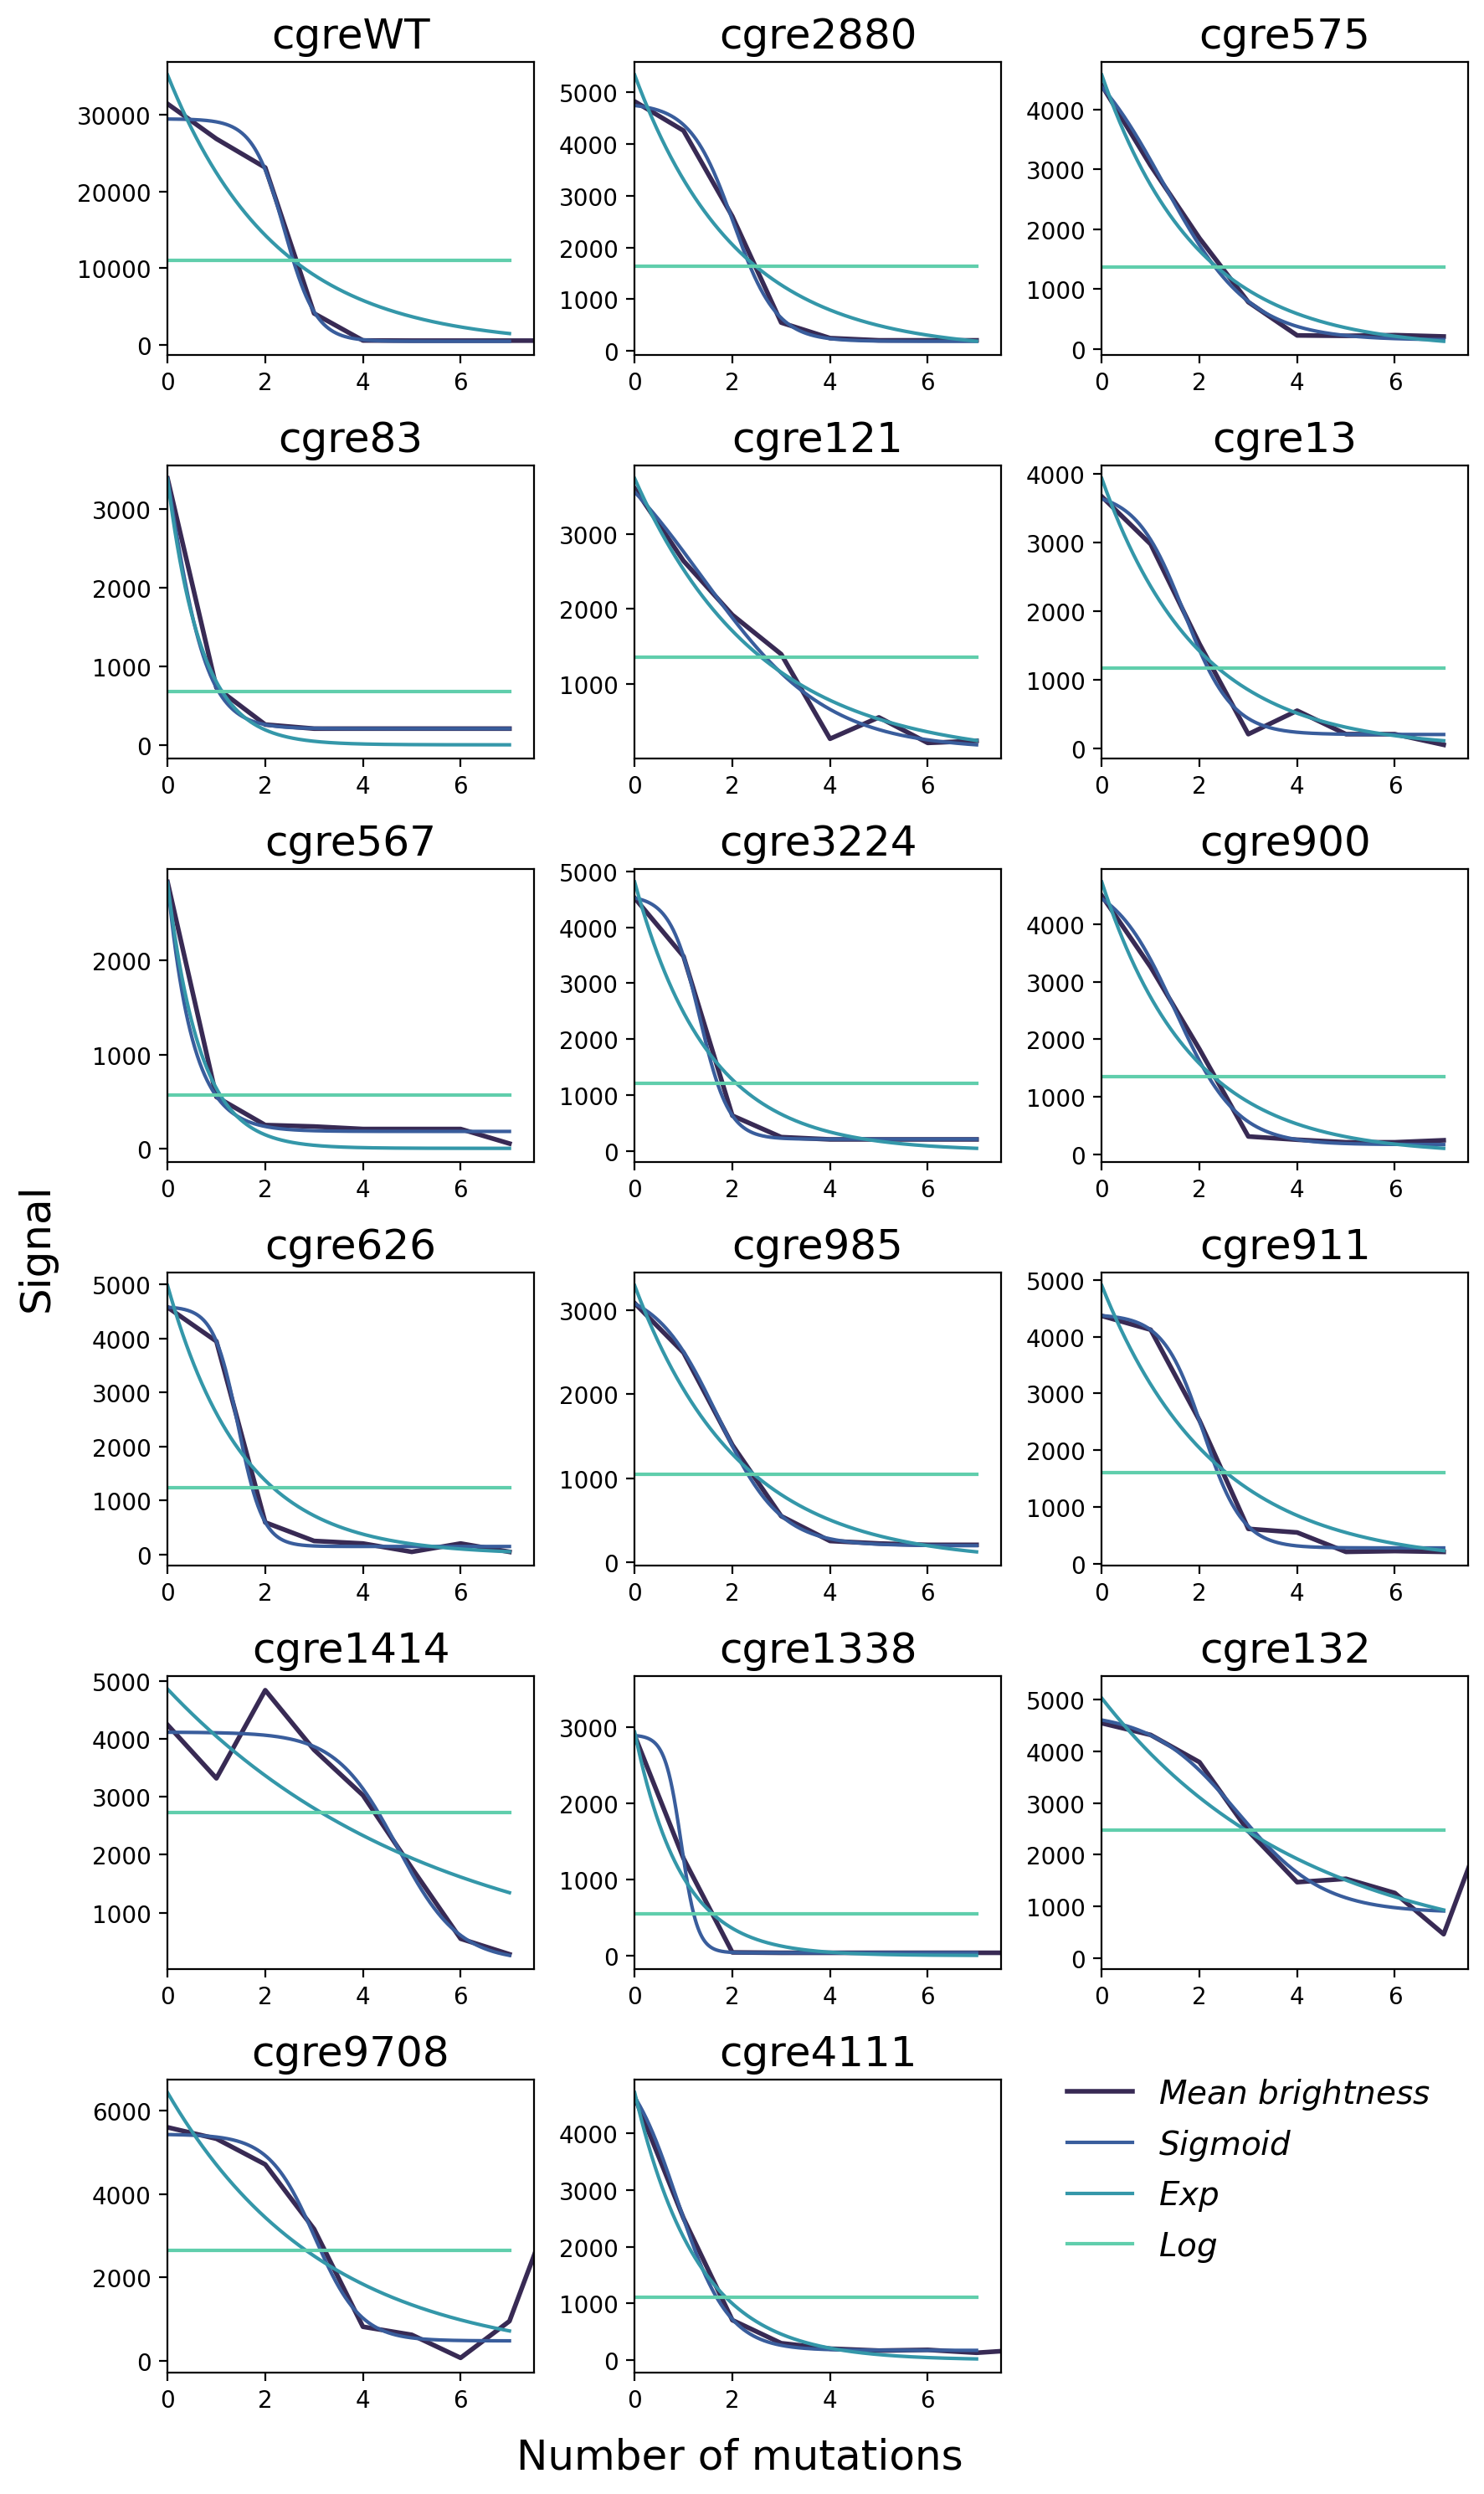

In [32]:
fig = plt.figure(figsize=[9, 15], dpi=200)
i = 1
sigm_params = {}

metrics_per_gene = {}

for gene in ["cgreGFP", 2880, 575, 83, 121, 13, 567,
             3224, 900, 626, 985, 911, 1414,
             1338, 132, 9708, 4111]:
    plot = plt.subplot(6, 3, i)

    sns.lineplot(data=mut_rob_df[(mut_rob_df.gene == gene)],
                 x='n_aamut', y='brightness',
                 linewidth=2, ci=None,
                 estimator='median', color=sns.color_palette("mako", n_colors=4)[0])

    muts = [list(mut_rob_df[(mut_rob_df.gene == gene) & (mut_rob_df.n_aamut == i)]['brightness']) for i in
            range(1, 8)]
    
    median_brightness_per_mut = mut_rob_df[(mut_rob_df.gene == gene) & (mut_rob_df.n_aamut <= 7)].groupby('n_aamut', as_index=False).median()
    x = median_brightness_per_mut.n_aamut
    y = median_brightness_per_mut.brightness

    # Sigmoid
    # Initial params
    sigm_p0 = [max(y), np.median(x), 1, min(y)] 
    # Fitting
    sigm_popt, sigm_pcov = curve_fit(sigmoid, x, y, sigm_p0, method='lm', maxfev=10000)
    
    sigm_x = np.linspace(0, 7, 1000)
    sigm_y = sigmoid(sigm_x, *sigm_popt)
    plt.plot(sigm_x, sigm_y, label='sigmoid', c=sns.color_palette("mako", n_colors=4)[1])

    # Exponential
    # Initial params
    exp_p0 = [np.max(y), np.median(x)]
    # Fitting
    exp_popt, exp_pcov = curve_fit(exponential, x, y, exp_p0, method='lm')
    exp_x = np.linspace(0, 7, 1000)
    exp_y = exponential(exp_x, *exp_popt)
    plt.plot(exp_x, exp_y, label='exp', c=sns.color_palette("mako", n_colors=4)[2])
    
    # Logarithmic
    # Initial params
    log_p0 = [1, 1, 1]
    # Fitting
    log_popt, log_pcov = curve_fit(logarithmic, x, y, log_p0, method='lm')
    
    log_x = np.linspace(0, 7, 1000)
    log_y = logarithmic(log_x, *log_popt)
    plt.plot(log_x, log_y, label='log', c=sns.color_palette("mako", n_colors=4)[3])
    
    # Non-parametric correlation coeffecient (no presumptions about data)
    sigm_pred_y = sigmoid(x, *sigm_popt)
    exp_pred_y = exponential(x, *exp_popt)
    log_pred_y = logarithmic(x, *log_popt)
    metrics_per_gene[gene] = {
                                    "kendall_sigm": kendalltau(y, sigm_pred_y).correlation,
                                    "kendall_exp": kendalltau(y, exp_pred_y).correlation,
                                    "kendall_log": kendalltau(y, log_pred_y).correlation,
                                    "mse_sigm": mean_squared_error(y, sigm_pred_y), 
                                    "mse_exp": mean_squared_error(y, exp_pred_y),
                                    "mse_log": mean_squared_error(y, log_pred_y),
    }
    
    # Saving params for sigm, as the best fitting
    sigm_params[gene] = sigm_popt
    
    plt.xlabel(None)
    plt.ylabel(None)
    plt.title(f"cgre{gene if gene != 'cgreGFP' else 'WT'}", fontsize=18)
   # plt.legend(loc='upper right', frameon=False)
    plt.xlim(0, 7.5)
    i += 1

fig.legend(
    #handles=[sigm_line[0], exp_line[0], log_line[0]],
    labels=["$Mean\ brightness$", "$Sigmoid$", "$Exp$", "$Log$"],
    bbox_to_anchor=(0.967, 0.175),
    borderaxespad=0,
    fontsize=14,
    frameon=False,
)
    
fig.supxlabel("Number of mutations", fontsize=18)
fig.supylabel("Signal", fontsize=18)
plt.tight_layout()
plt.savefig("mut_robust.png", dpi=300)

In [8]:
mut_rob_df.head()

,gene,brightness,n_aamut
35500,cgreGFP,23170.425067,1
35501,cgreGFP,31398.869978,0
35502,cgreGFP,29529.665763,1
35503,cgreGFP,590.000000,3
35504,cgreGFP,6848.833382,3


## Metrics:

In [ ]:
pd.DataFrame(metrics_per_gene).T

## Sigmoid best fitting -> Inverse

Inverse of the sigmoid function:
$$
    y = \frac{L}{  (1 + e^{-k \cdot (x-x_0)})} + b
$$

$$
(y - b) = \frac{L}{  (1 + e^{-k \cdot (x-x_0)})} \\
 (1 + e^{-k \cdot (x-x_0)}) = \frac{L}{ (y - b) } \\
  e^{-k \cdot (x-x_0)} = \frac{L}{ (y - b) } - 1 \\
  -k \cdot (x-x_0) = ln(\frac{L}{ (y - b) } - 1) \\
  x = - \frac{ln(\frac{L}{ (y - b) } - 1)}{k} + x_0 \\
$$

In [27]:
half_mut_rob_per_gene = {}
for gene, sigm_popt in sigm_params.items():
    median_brightness_per_mut = (
        mut_rob_df[(mut_rob_df.gene == gene) & (mut_rob_df.n_aamut <= 7)]
        .groupby("n_aamut", as_index=False)
        .median()
    )
    y_half = np.max(median_brightness_per_mut.brightness) / 2
    half_mut_rob_per_gene[gene] = inverse_sigmoid(y_half, *sigm_popt)

In [25]:
half_mut_rob_per_gene

{'cgreGFP': 2.3598224708239237,
 2880: 2.0475472322138573,
 575: 1.648929743078233,
 83: 0.4876710628582579,
 121: 2.087983470121052,
 13: 1.7655853131041812,
 567: 0.38997176295167435,
 3224: 1.364926200088591,
 900: 1.6385128907623048,
 626: 1.4664978833021196,
 985: 1.8639110762878979,
 911: 2.1317630470636817,
 1414: 4.5209917944211,
 1338: 0.9603722537683815,
 132: 3.2927772016988577,
 9708: 3.077040183325697,
 4111: 1.072414674710171}

In [28]:
median_brightness_per_mut

,n_aamut,brightness
0,0,4638.446502
1,1,2502.127085
2,2,704.732459
3,3,297.497417
4,4,201.476032
5,5,167.240160
6,6,180.285878
7,7,128.853943


In [29]:
half_mut_rob_per_gene = {}
for gene, sigm_popt in sigm_params.items():
    median_brightness_per_mut = (
        mut_rob_df[(mut_rob_df.gene == gene) & (mut_rob_df.n_aamut <= 7)]
        .groupby("n_aamut", as_index=False)
        .median()
    )
    y_half = median_brightness_per_mut.brightness[0] / 2
    half_mut_rob_per_gene[gene] = inverse_sigmoid(y_half, *sigm_popt)